### Benchmark Models

In [13]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

### Preprocessing Pipeline

In [2]:
def preprocess_data(df, test_size=0.2, random_state=42):
    # Define target variables and feature variables
    X = df.drop(columns=['DEP_DATE_TIME', 'ACC_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP', 'WEATHER_DELAY', 'CANCELLED'])
    y = df['DEP_DELAY_GROUP'].replace({-2: 0, -1: 0})  # Replace -2 and -1 with 0
    
    # Define numerical and categorical columns
    categorical_cols = ['ORIGIN', 'DEST']
    numerical_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Train-test split (not random, but sequential)
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    
    # Ensure encoder learns all categories, even those missing in training
    all_categories = {col: X[col].unique() for col in categorical_cols}
    
    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(categories=[all_categories[col] for col in categorical_cols], drop='first', handle_unknown='ignore'), categorical_cols)
        ])
    
    # Preprocess the data (Fit on training data and transform both training and test data)
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_torch = torch.FloatTensor(X_train_processed.toarray())
    Y_train_torch = torch.LongTensor(Y_train.values)
    X_test_torch = torch.FloatTensor(X_test_processed.toarray())
    Y_test_torch = torch.LongTensor(Y_test.values)
    
    # Normalize data
    scaler = StandardScaler()
    X_train_torch = torch.tensor(scaler.fit_transform(X_train_torch), dtype=torch.float32)
    X_test_torch = torch.tensor(scaler.transform(X_test_torch), dtype=torch.float32)
    
    # Generate feature names after OneHotEncoding for categorical columns
    categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = numerical_cols + list(categorical_feature_names)
    
    return X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names

### Random Forest Function

In [3]:
def train_random_forest(X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names):

    # Convert PyTorch tensors to NumPy arrays
    X_train_np = X_train_torch.numpy()
    X_test_np = X_test_torch.numpy()
    Y_train_np = Y_train_torch.numpy()
    Y_test_np = Y_test_torch.numpy()

    # Initialize Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=100,  # Number of trees
        max_depth=10,       # Max depth for each tree
        min_samples_leaf=50,  # Minimum samples per leaf
        min_samples_split=50,  # Minimum samples to split a node
        max_leaf_nodes=12,  # Max leaf nodes for each tree
        random_state=42
    )
    
    # Train the model
    rf_model.fit(X_train_np, Y_train_np)
    
    # Make predictions
    y_pred_train = rf_model.predict(X_train_np)
    y_pred_test = rf_model.predict(X_test_np)

    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(Y_train_np, y_pred_train),
        'train_precision': precision_score(Y_train_np, y_pred_train, average='weighted'),
        'train_recall': recall_score(Y_train_np, y_pred_train, average='weighted'),
        'train_f1': f1_score(Y_train_np, y_pred_train, average='weighted'),
        'test_accuracy': accuracy_score(Y_test_np, y_pred_test),
        'test_precision': precision_score(Y_test_np, y_pred_test, average='weighted'),
        'test_recall': recall_score(Y_test_np, y_pred_test, average='weighted'),
        'test_f1': f1_score(Y_test_np, y_pred_test, average='weighted')
    }

    # Print metrics
    print("\nTraining Set Metrics:")
    for key in metrics:
        if 'train' in key:
            print(f"{key.replace('_', ' ').title()}: {metrics[key]:.4f}")

    print("\nTest Set Metrics:")
    for key in metrics:
        if 'test' in key:
            print(f"{key.replace('_', ' ').title()}: {metrics[key]:.4f}")

    # Feature importance plot
    importance_data = pd.DataFrame({'Feature': feature_names, 'Importance': rf_model.feature_importances_})
    importance_data = importance_data[importance_data['Importance'] > 0].sort_values('Importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(importance_data['Feature'], importance_data['Importance'], color='skyblue', edgecolor='navy')
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Feature Importance in Random Forest', fontsize=14, pad=20)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.savefig('rf_feature_importance_plot.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    
    return rf_model, metrics


### LSTM Function

In [4]:
from torch.utils.data import DataLoader, TensorDataset

def train_lstm(X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, hidden_size=64, num_epochs=100, batch_size=64, lr=0.001):
    # Define LSTM model class
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super(LSTMModel, self).__init__()
            self.hidden_size = hidden_size
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  # LSTM layer
            self.fc = nn.Linear(hidden_size, num_classes)  # Fully connected layer

        def forward(self, x):
            x = x.unsqueeze(1)  # Reshape input to (batch_size, 1, input_size)
            out, _ = self.lstm(x)  # LSTM forward pass
            out = out[:, -1, :]  # Get the last time step's output
            out = self.fc(out)  # Fully connected layer
            return out

    # Model hyperparameters
    input_size = X_train_torch.shape[1]  
    num_classes = len(torch.unique(Y_train_torch))  

    # Initialize model
    model = LSTMModel(input_size, hidden_size, num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader setup
    train_data = TensorDataset(X_train_torch, Y_train_torch)
    test_data = TensorDataset(X_test_torch, Y_test_torch)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Tracking loss and accuracy
    train_loss_list = []
    train_accuracy_list = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)  
            loss = criterion(outputs, batch_y)  
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        # Average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(train_loader)
        avg_accuracy = correct / total
        train_loss_list.append(avg_loss)
        train_accuracy_list.append(avg_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    # Evaluate on test set
    model.eval()
    y_pred_test = []
    y_true_test = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            y_pred_test.extend(predicted.cpu().numpy())
            y_true_test.extend(batch_y.cpu().numpy())

    # Calculate metrics
    test_accuracy = accuracy_score(y_true_test, y_pred_test)
    test_precision = precision_score(y_true_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_true_test, y_pred_test, average='weighted')
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted')

    # Store metrics in a dictionary
    metrics = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1
    }

    # Print evaluation metrics
    print(f'\nTest Set Metrics:')
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'Recall: {test_recall:.4f}')
    print(f'F1-score: {test_f1:.4f}')

    # Plot loss
    plt.figure(figsize=(4, 4))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Across Epochs')
    plt.legend()
    plt.savefig('training_loss_plot_LSTM.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(4, 4))
    plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.legend()
    plt.savefig('training_accuracy_plot_LSTM.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return the model and the evaluation metrics
    return model, metrics

### Ensemble Model Function

In [14]:
def train_rf_then_lstm(X_train_torch, X_test_torch, Y_train_torch, Y_test_torch, feature_names, 
                        top_n_features=10, hidden_size=64, num_epochs=100, batch_size=64, lr=0.001):

    # Convert PyTorch tensors to NumPy arrays for RF
    X_train_np = X_train_torch.numpy()
    X_test_np = X_test_torch.numpy()
    Y_train_np = Y_train_torch.numpy()
    Y_test_np = Y_test_torch.numpy()

    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train_np, Y_train_np)

    # Get feature importances
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': rf_model.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Select top N important features
    top_features = feature_importance.head(top_n_features)['Feature'].tolist()
    top_feature_indices = [feature_names.index(feat) for feat in top_features]

    # Reduce dataset to selected features
    X_train_selected = X_train_torch[:, top_feature_indices]
    X_test_selected = X_test_torch[:, top_feature_indices]

    # Define LSTM Model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            x = x.unsqueeze(1)  # Reshape input to (batch_size, 1, input_size)
            out, _ = self.lstm(x)
            out = out[:, -1, :]
            out = self.fc(out)
            return out

    # Initialize model
    input_size = X_train_selected.shape[1]
    num_classes = len(torch.unique(Y_train_torch))
    model = LSTMModel(input_size, hidden_size, num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader setup
    train_data = TensorDataset(X_train_selected, Y_train_torch)
    test_data = TensorDataset(X_test_selected, Y_test_torch)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Training loop
    train_loss_list = []
    train_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        avg_loss = epoch_loss / len(train_loader)
        avg_accuracy = correct / total
        train_loss_list.append(avg_loss)
        train_accuracy_list.append(avg_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    # Evaluate on test set
    model.eval()
    y_pred_test = []
    y_true_test = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            y_pred_test.extend(predicted.cpu().numpy())
            y_true_test.extend(batch_y.cpu().numpy())

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true_test, y_pred_test),
        'precision': precision_score(y_true_test, y_pred_test, average='weighted'),
        'recall': recall_score(y_true_test, y_pred_test, average='weighted'),
        'f1_score': f1_score(y_true_test, y_pred_test, average='weighted')
    }

    # Print metrics
    print("\nTest Set Metrics:")
    for key, value in metrics.items():
        print(f"{key.title()}: {value:.4f}")

    # Plot accuracy and loss
    plt.figure(figsize=(4, 4))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Across Epochs')
    plt.legend()
    plt.savefig('training_loss_plot_LSTM.png', dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Across Epochs')
    plt.legend()
    plt.savefig('training_accuracy_plot_LSTM.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model, metrics

### JFK Models

In [6]:
# import dataset
merged_jfk_df = pd.read_csv('merged_df.csv')

In [7]:
# preprocessing
X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk = preprocess_data(merged_jfk_df)

c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\mlpractical\mlp\MLP_Project\mlpc\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Train Accuracy: 0.8383
Train Precision: 0.7028
Train Recall: 0.8383
Train F1: 0.7646

Test Set Metrics:
Test Accuracy: 0.8244
Test Precision: 0.6796
Test Recall: 0.8244
Test F1: 0.7450


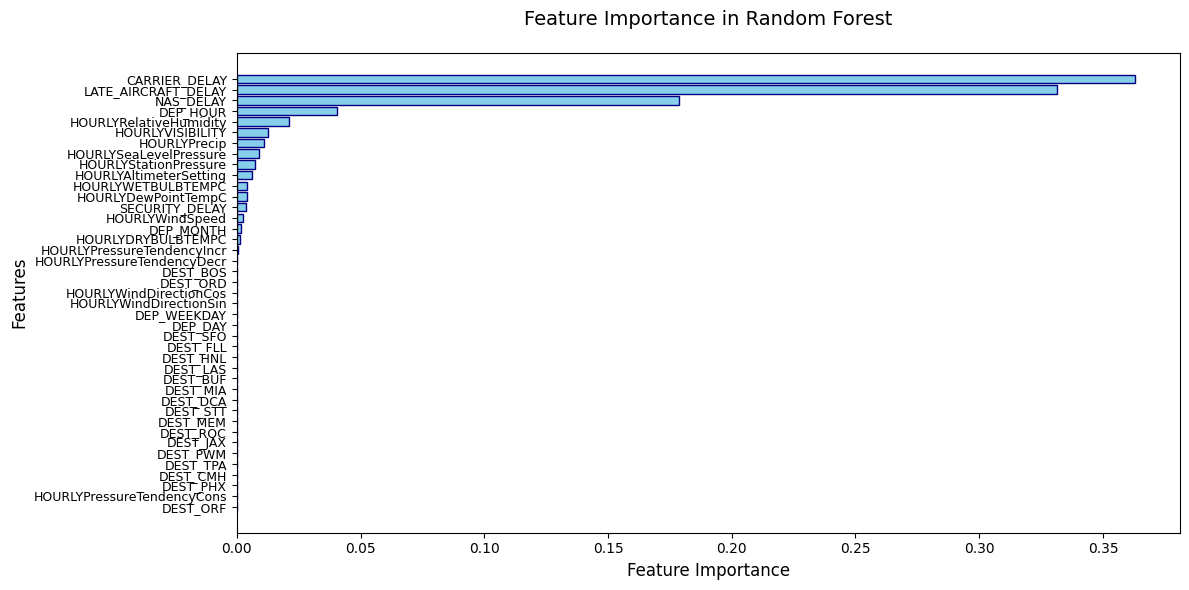

In [9]:
jfk_RF_model, jfk_metrics_RF = train_random_forest(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

Epoch [10/100], Loss: 0.2151, Accuracy: 0.9274
Epoch [20/100], Loss: 0.2067, Accuracy: 0.9297
Epoch [30/100], Loss: 0.2025, Accuracy: 0.9308
Epoch [40/100], Loss: 0.2000, Accuracy: 0.9315
Epoch [50/100], Loss: 0.1979, Accuracy: 0.9322
Epoch [60/100], Loss: 0.1965, Accuracy: 0.9327
Epoch [70/100], Loss: 0.1953, Accuracy: 0.9333
Epoch [80/100], Loss: 0.1946, Accuracy: 0.9336
Epoch [90/100], Loss: 0.1936, Accuracy: 0.9338
Epoch [100/100], Loss: 0.1930, Accuracy: 0.9340

Test Set Metrics:
Accuracy: 0.9172
Precision: 0.9098
Recall: 0.9172
F1-score: 0.9130


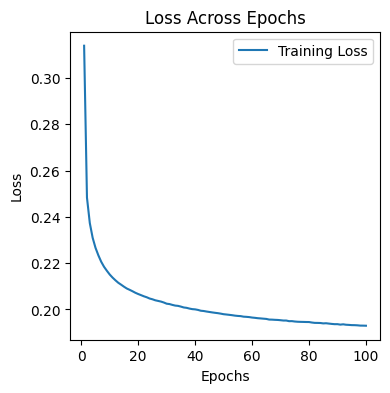

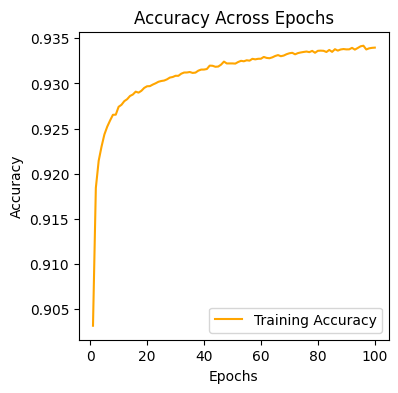

In [10]:
jfk_LSTM_model, jfk_metrics_LSTM = train_lstm(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk)

Epoch [10/100], Loss: 0.2222, Accuracy: 0.9283
Epoch [20/100], Loss: 0.2142, Accuracy: 0.9302
Epoch [30/100], Loss: 0.2107, Accuracy: 0.9311
Epoch [40/100], Loss: 0.2088, Accuracy: 0.9314
Epoch [50/100], Loss: 0.2074, Accuracy: 0.9318
Epoch [60/100], Loss: 0.2064, Accuracy: 0.9320
Epoch [70/100], Loss: 0.2056, Accuracy: 0.9322
Epoch [80/100], Loss: 0.2049, Accuracy: 0.9324
Epoch [90/100], Loss: 0.2042, Accuracy: 0.9324
Epoch [100/100], Loss: 0.2038, Accuracy: 0.9326

Test Set Metrics:
Accuracy: 0.9229
Precision: 0.9167
Recall: 0.9229
F1_Score: 0.9191


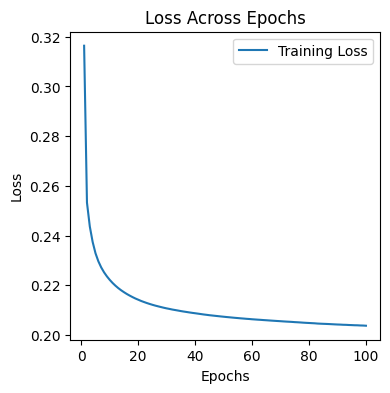

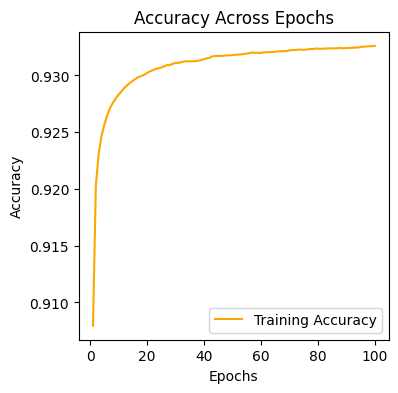

In [15]:
jfk_RFLSTM_model, JFK_metrics_RFLSTM = train_rf_then_lstm(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

tutorial notes:
- keep decision tree and random forest parameters the same (e.g. depth and min leafs)
- try training with full set of features, and top 10
- PCA? corrplots?
- training and test not random - first 80%, last 20%
- remove weather delay feature

NEED TO DO SHAP ANALYSIS FOR EACH MODEL

generalisation experiments:
- train and test on all airports (80/20 split)
- train on full JFK airport, test on other airports